In [1]:
!pip install networkx 
!pip install opencv-python --quiet

In [73]:
import networkx as nx
from copy import deepcopy
import math
import numpy as np
from tqdm import tqdm

In [27]:
import matplotlib.pyplot as plt

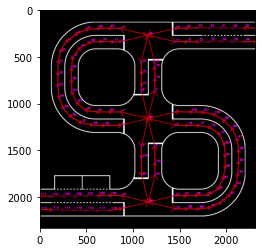

In [28]:
G = nx.read_graphml('test_track.graphml')
import cv2
img=cv2.imread("Test_track.png")
plt.imshow(img)

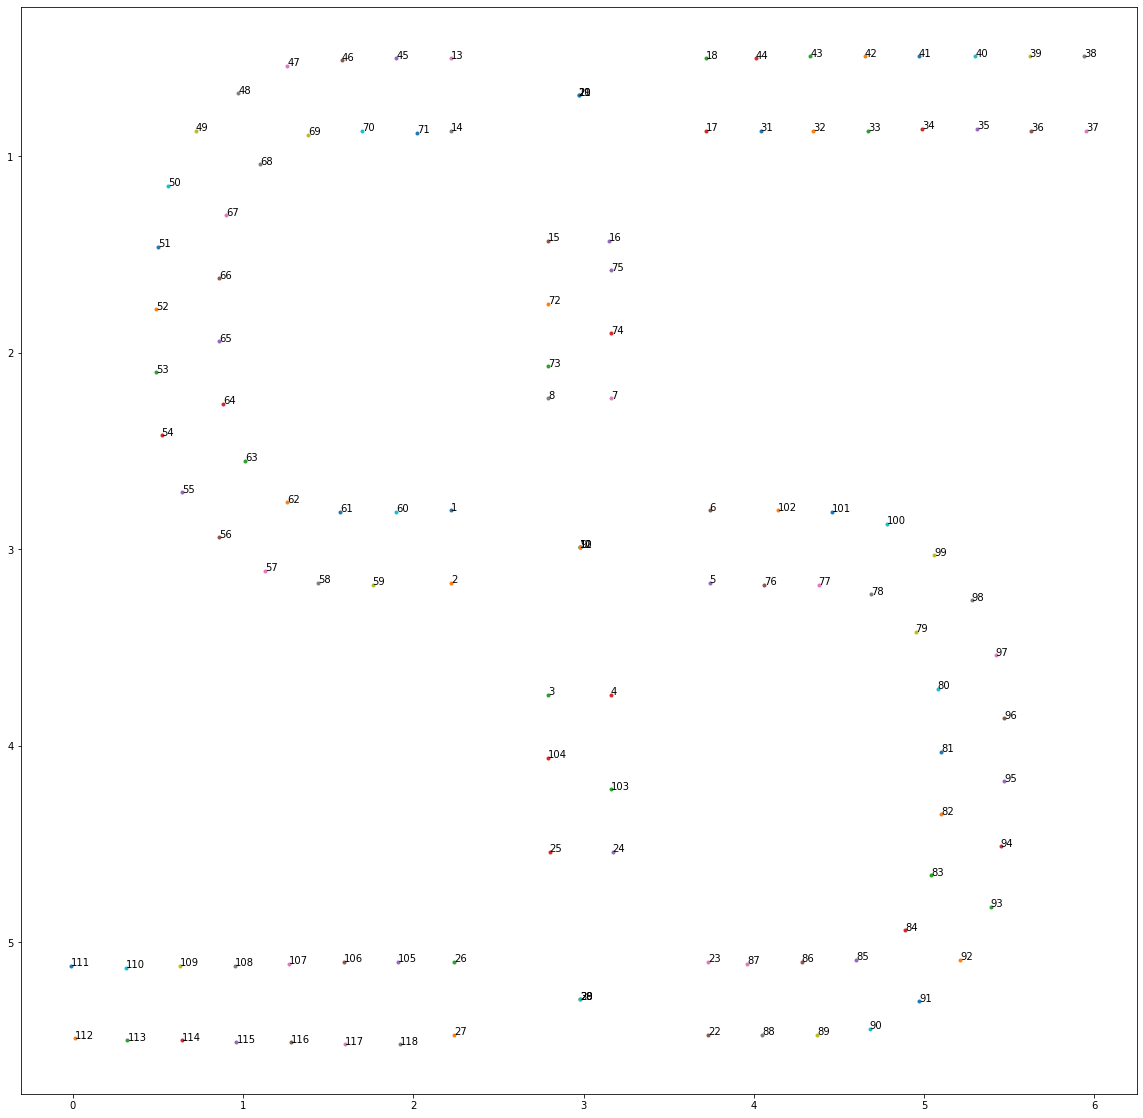

In [29]:
plt.figure(figsize=(20,20))
for node,data in G.nodes(data=True):
    plt.plot(data['x'],data['y'],'.')
    ax = plt.gca()
    ax.annotate(str(node), (data['x'],data['y'])) 

ax = plt.gca()
ax.invert_yaxis()
# plt.legend()
# plt.show()

In [30]:
for i in G.neighbors('24'):
    print(i)

147


In [31]:
import heapq
def dijkstra(G, start, target):
    d = {start: 0}
    parent = {start: None}
    pq = [(0, start)]
    visited = set()
    while pq:
        du, u = heapq.heappop(pq)
        if u in visited:
            continue
        if u == target:
            break
        visited.add(u)
        for v  in G.adj[u]:
            if v not in d or d[v] > du + 1:
                d[v] = du + 1
                parent[v] = u
                heapq.heappush(pq, (d[v], v))

    fp = [target]
    tg = target

    while tg != start:
        fp.insert(0, parent[tg])
        tg = parent[tg]

    return fp

In [32]:
path_list=dijkstra(G,'112','67')

In [33]:
G["86"]

AtlasView({'87': {'dotted': False}})

In [34]:
node_dict=G.nodes(data=True)

In [35]:
node_dict['86']

{'x': 4.28, 'y': 5.1}

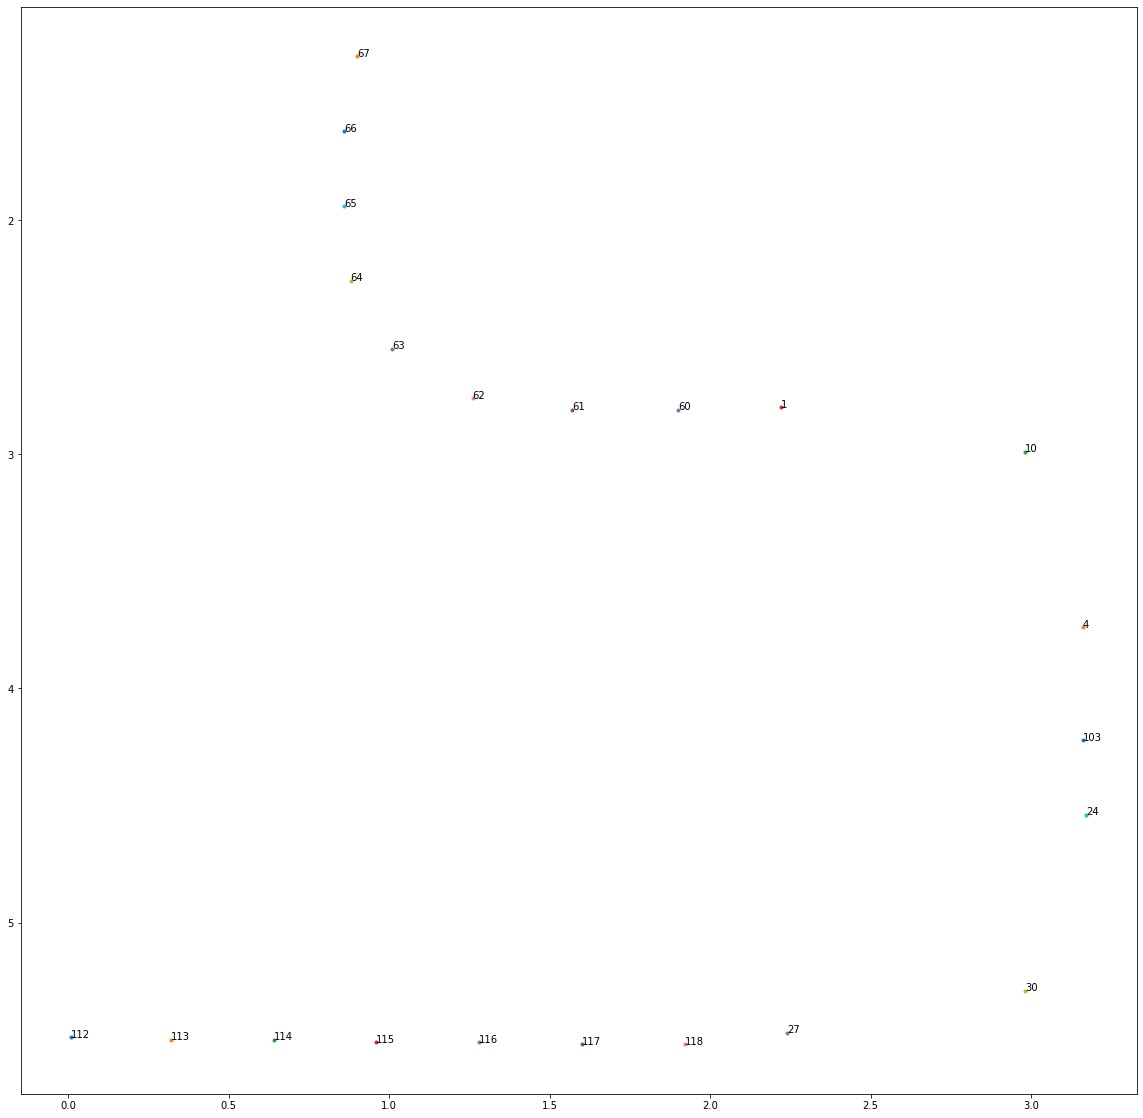

In [36]:
coord_list=[]
plt.figure(figsize=(20,20))
for i in path_list:
    data=node_dict[i]
    plt.plot(data['x'],data['y'],'.')
    coord_list.append([data['x'],data['y']])
    ax = plt.gca()
    ax.annotate(str(i), (data['x'],data['y'])) 

# plt.xlim(0,6)
# plt.ylim(0,6)


ax = plt.gca()
ax.invert_yaxis()

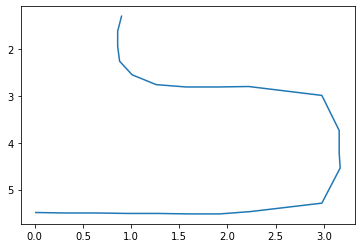

In [37]:
x, y = zip(*coord_list)
plt.plot(x,y)
ax = plt.gca()
ax.invert_yaxis()

In [38]:
coord_list

[[0.01, 5.49],
 [0.32, 5.5],
 [0.64, 5.5],
 [0.96, 5.51],
 [1.28, 5.51],
 [1.6, 5.52],
 [1.92, 5.52],
 [2.24, 5.47],
 [2.98, 5.29],
 [3.17, 4.54],
 [3.16, 4.22],
 [3.16, 3.74],
 [2.98, 2.99],
 [2.22, 2.8],
 [1.9, 2.81],
 [1.57, 2.81],
 [1.26, 2.76],
 [1.01, 2.55],
 [0.88, 2.26],
 [0.86, 1.94],
 [0.86, 1.62],
 [0.9, 1.3]]

# path smoothing

suck a dick dipshit

In [39]:
def path_smooth(path, weight_data:float = 0.1, weight_smooth:float = 0.05, tolerance:float = 1e-6):
    new_path = deepcopy(path)
    dims = len(path[0])
    change = tolerance
    while change >= tolerance:
        change = 0.0
        for i in range(1, len(new_path) -1 ):
            for j in range(dims):
                x_i = path[i][j]
                y_i, y_prev, y_next = new_path[i][j], new_path[i - 1][j], new_path[i+1][j]
                y_i_saved = y_i
                y_i += weight_data * (x_i - y_i) + weight_smooth * (y_next + y_prev - (2*y_i))
                
                new_path[i][j] = y_i
                change = abs(y_i - y_i_saved)
    return new_path

In [40]:
coord_list_smooth = path_smooth(coord_list)

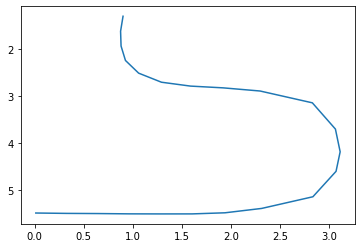

In [41]:
x, y = zip(*coord_list_smooth)
plt.plot(x,y)
ax = plt.gca()
ax.invert_yaxis()

## Pure Pursuit

In [87]:
"""
Path tracking simulation with pure pursuit steering and PID speed control.
author: Atsushi Sakai (@Atsushi_twi)
        Guillaume Jacquenot (@Gjacquenot)
"""
import numpy as np
import math
import matplotlib.pyplot as plt

# Parameters
k = 0.01  # look forward gain
Lfc = .50  # [m] look-ahead distance
Kp = 1.0  # speed proportional gain
dt = 0.1  # [s] time tick
WB = 0.3  # [m] wheel base of vehicle

show_animation = True


class State:
    def __init__(self, v=14, dt=0.1, l=0.365) -> None:
        self.steering_angle = 0.0
        self.det_intersection = False
        self.x = 0.83  # TODO
        self.y = 6.67  # TODO
        self.yaw = math.pi/2
        self.tl = {}
        self.v = v
        self.dt = dt
        self.l = l
        self.rear_x = self.x - ((l / 2) * math.cos(self.yaw))
        self.rear_y = self.y - ((l / 2) * math.sin(self.yaw))

    def update_pos(self, steering_angle):
        self.x = self.x + self.v * math.cos(self.yaw) * self.dt
        self.y = self.y + self.v * math.sin(self.yaw) * self.dt
        self.yaw = (
            self.yaw + self.v / self.l * math.tan(steering_angle) * self.dt
        )  # steering_angle is the steering angle
        self.rear_x = self.x - ((WB / 2) * math.cos(self.yaw))
        self.rear_y = self.y - ((WB / 2) * math.sin(self.yaw))

    def update(
        self,
        angle: float,
        det_intersection: bool,
        x: float,
        y: float,
        yaw: float,
        tl: dict,
    ) -> None:
        self.steering_angle = angle
        self.det_intersection = det_intersection
        self.x = x
        self.y = y
        self.yaw = yaw
        self.tl = tl
        
    def calc_distance(self, point_x, point_y):
        dx = self.rear_x - point_x
        dy = self.rear_y - point_y
        return math.hypot(dx, dy)
    
    def __repr__(self) -> str:
        return f"{datetime.datetime.now()}| {self.steering_angle}, {self.det_intersection}, {self.x}, {self.y}, {self.yaw}"

    def asdict(self) -> dict:
        return {"angle": self.steering_angle, "intersection": self.det_intersection}


class States:

    def __init__(self):
        self.x = []
        self.y = []
        self.yaw = []
        self.v = []
        self.t = []

    def append(self, t, state):
        self.x.append(state.x)
        self.y.append(state.y)
        self.yaw.append(state.yaw)
        self.v.append(state.v)
        self.t.append(t)


def proportional_control(target, current):
    a = Kp * (target - current)

    return a


class TargetCourse:

    def __init__(self, cx, cy):
        self.cx = cx
        self.cy = cy
        self.old_nearest_point_index = None

    def search_target_index(self, state):

        # To speed up nearest point search, doing it at only first time.
        if self.old_nearest_point_index is None:
            # search nearest point index
            dx = [state.rear_x - icx for icx in self.cx]
            dy = [state.rear_y - icy for icy in self.cy]
            d = np.hypot(dx, dy)
            ind = np.argmin(d)
            self.old_nearest_point_index = ind
        else:
            ind = self.old_nearest_point_index
            distance_this_index = state.calc_distance(self.cx[ind],
                                                      self.cy[ind])
            while True:
                distance_next_index = state.calc_distance(self.cx[ind + 1],
                                                          self.cy[ind + 1])
                if distance_this_index < distance_next_index:
                    break
                ind = ind + 1 if (ind + 1) < len(self.cx) else ind
                distance_this_index = distance_next_index
            self.old_nearest_point_index = ind

        Lf = k * state.v + Lfc  # update look ahead distance

        # search look ahead target point index
        while Lf > state.calc_distance(self.cx[ind], self.cy[ind]):
            if (ind + 1) >= len(self.cx):
                break  # not exceed goal
            ind += 1

        return ind, Lf


def pure_pursuit_steer_control(state, trajectory, pind):
    ind, Lf = trajectory.search_target_index(state)

    if pind >= ind:
        ind = pind

    if ind < len(trajectory.cx):
        tx = trajectory.cx[ind]
        ty = trajectory.cy[ind]
    else:  # toward goal
        tx = trajectory.cx[-1]
        ty = trajectory.cy[-1]
        ind = len(trajectory.cx) - 1

    alpha = math.atan2(ty - state.rear_y, tx - state.rear_x) - state.yaw

    delta = math.atan2(2.0 * WB * math.sin(alpha) / Lf, 1.0)

    return delta, ind


def plot_arrow(x, y, yaw, length=.01, width=0.005, fc="r", ec="k"):
    """
    Plot arrow
    """

    if not isinstance(x, float):
        for ix, iy, iyaw in zip(x, y, yaw):
            plot_arrow(ix, iy, iyaw)
    else:
        plt.arrow(x, y, length * math.cos(yaw), length * math.sin(yaw),
                  fc=fc, ec=ec, head_width=width, head_length=width)
        plt.plot(x, y)



Pure pursuit path tracking simulation start


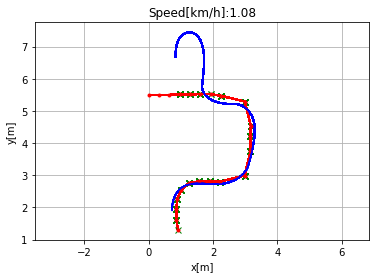

In [90]:
def main():
    #  target course
    cx, cy = zip(*coord_list)
    target_speed = 10.0 / 3.6  # [m/s]

    T = 100.0  # max simulation time

    # initial state
    state = State(v=0.3)

    lastIndex = len(cx) - 1
    time = 0.0
    states = States()
    states.append(time, state)
    target_course = TargetCourse(cx, cy)
    target_ind, _ = target_course.search_target_index(state)

    while T >= time and lastIndex > target_ind:

        # Calc control input
        ai = proportional_control(target_speed, state.v)
        di, target_ind = pure_pursuit_steer_control(
            state, target_course, target_ind)

        state.update_pos(di)  # Control vehicle

        time += dt
        states.append(time, state)

        if show_animation:  # pragma: no cover
            # plt.cla()
            # for stopping simulation with the esc key.
            # plt.gcf().canvas.mpl_connect(
            #     'key_release_event',
            #     lambda event: [exit(0) if event.key == 'escape' else None])
            plot_arrow(state.x, state.y, state.yaw)
            plt.plot(cx, cy, "-r", label="course")
            plt.plot(states.x, states.y, "-b", label="trajectory")
            plt.plot(cx[target_ind], cy[target_ind], "xg", label="target")
            plt.axis("equal")
            plt.grid(True)
            plt.title("Speed[km/h]:" + str(state.v * 3.6)[:4])
            # plt.pause(0.001)

    # Test
    assert lastIndex >= target_ind, "Cannot goal"

    if show_animation:  # pragma: no cover
        # plt.cla()
        plt.plot(cx, cy, ".r", label="course")
        plt.plot(states.x, states.y, "-b", label="trajectory")
        plt.xlabel("x[m]")
        plt.ylabel("y[m]")
        plt.axis("equal")
        plt.grid(True)

        # plt.subplots(1)
        #plt.plot(states.t, [iv * 3.6 for iv in states.v], "-r")
        #plt.xlabel("Time[s]")
        #plt.ylabel("Speed[km/h]")
        #plt.grid(True)
        # plt.show()


if __name__ == '__main__':
    print("Pure pursuit path tracking simulation start")
    main()

In [112]:
class Purest_Pursuit:
    def __init__(self):
        k = 0.01  # look forward gain
        Lfc = .50  # [m] look-ahead distance
        Kp = 1.0  # speed proportional gain
        dt = 0.1  # [s] time tick
        WB = 0.3  # [m] wheel base of vehicle
        
        
    def pure_pursuit_steer_control(self,state, trajectory):
        ind, Lf = trajectory.search_target_index(state)

        if ind < len(trajectory.cx):
            tx = trajectory.cx[ind]
            ty = trajectory.cy[ind]
        else:  # toward goal
            tx = trajectory.cx[-1]
            ty = trajectory.cy[-1]
            ind = len(trajectory.cx) - 1

        alpha = math.atan2(ty - state.rear_y, tx - state.rear_x) - state.yaw

        delta = math.atan2(2.0 * WB * math.sin(alpha) / Lf, 1.0)

        return delta
        
    def get_steering_angle(self,coord_list):
        cx,cy = zip(*coord_list)
        target_course = TargetCourse(cx, cy)
        target_ind, _ = target_course.search_target_index(state)

        di, target_ind = pure_pursuit_steer_control(
            state, target_course)


IndexError: tuple index out of range

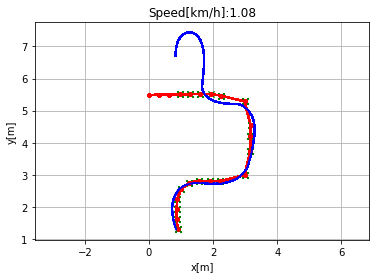

In [117]:
time = 0.0
T = 1000
cx, cy = zip(*coord_list)
pursuit = Purest_Pursuit()
state = State(v=0.3)
states = States()
target_course = TargetCourse(cx, cy)

    
while T >= time:
    # Calc control input
    target_ind, Lf = target_course.search_target_index(state)
    di = pursuit.pure_pursuit_steer_control(
            state, target_course)

    state.update_pos(di)  # Control vehicle

    time += dt
    states.append(time, state)

    if show_animation:  # pragma: no cover
            # plt.cla()
            # for stopping simulation with the esc key.
            # plt.gcf().canvas.mpl_connect(
            #     'key_release_event',
            #     lambda event: [exit(0) if event.key == 'escape' else None])
        plot_arrow(state.x, state.y, state.yaw)
        plt.plot(cx, cy, "-r", label="course")
        plt.plot(states.x, states.y, "-b", label="trajectory")
        plt.plot(cx[target_ind], cy[target_ind], "xg", label="target")
        plt.axis("equal")
        plt.grid(True)
        plt.title("Speed[km/h]:" + str(state.v * 3.6)[:4])
            # plt.pause(0.001)

    # Test
    if show_animation:  # pragma: no cover
        # plt.cla()
        plt.plot(cx, cy, ".r", label="course")
        plt.plot(states.x, states.y, "-b", label="trajectory")
        # plt.legend()
        plt.xlabel("x[m]")
        plt.ylabel("y[m]")
        plt.axis("equal")
        plt.grid(True)
        # plt.show()    